In [1]:
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns

In [2]:
# Set default sizes for figures.
plt.style.use("default") # style matplotlib
plt.rc("axes", labelsize = 15) # fontsize of the x and y labels
plt.rc("axes", titlesize = 15) # fontsize of the axes title
plt.rc("xtick", labelsize = 15) # fontsize of the tick labels
plt.rc("ytick", labelsize = 15) # fontsize of the tick labels
plt.rc("legend", fontsize = 15) # legend fontsize

# Analysis

In [3]:
PROJECT_ROOT = "./RESULTS/2° Analysis"

## Configuration

In [4]:
# Load corresponding simulations (hyper-parameter tuning + forecasting) for each country.
COUNTRIES = ["Yemen", "Syria", "Burkina Faso", "Nigeria", "Mali", "Cameroon"] 

In [5]:
for country in COUNTRIES:
    print(country)
    # Load forecasting results for each split.
    xls = pd.ExcelFile(f"{PROJECT_ROOT}/{country}/standard/out_test/forecast.xlsx")

    for i, split in enumerate(xls.sheet_names[1:]):
        forecast_split = pd.read_excel(xls, split, index_col = 0, header = [0, 1, 2])
        print(f"{split}: {forecast_split.index[0].date()} - {forecast_split.index[-1].date()}")

Yemen
Split 1: 2021-03-01 - 2021-03-30
Split 2: 2021-04-01 - 2021-04-30
Split 3: 2021-05-01 - 2021-05-30
Split 4: 2021-06-01 - 2021-06-30
Split 5: 2021-07-01 - 2021-07-30
Split 6: 2021-08-01 - 2021-08-30
Split 7: 2021-09-01 - 2021-09-30
Split 8: 2021-10-01 - 2021-10-30
Split 9: 2021-11-01 - 2021-11-30
Split 10: 2021-12-01 - 2021-12-30
Split 11: 2022-01-01 - 2022-01-30
Split 12: 2022-02-01 - 2022-03-02
Split 13: 2022-03-01 - 2022-03-30
Syria
Split 1: 2021-05-01 - 2021-05-30
Split 2: 2021-06-01 - 2021-06-30
Split 3: 2021-07-01 - 2021-07-30
Split 4: 2021-08-01 - 2021-08-30
Split 5: 2021-09-01 - 2021-09-30
Split 6: 2021-10-01 - 2021-10-30
Split 7: 2021-11-01 - 2021-11-30
Split 8: 2021-12-01 - 2021-12-30
Split 9: 2022-01-01 - 2022-01-30
Split 10: 2022-02-01 - 2022-03-02
Burkina Faso
Split 1: 2021-09-01 - 2021-09-30
Split 2: 2021-10-01 - 2021-10-30
Split 3: 2021-11-01 - 2021-11-30
Split 4: 2021-12-01 - 2021-12-30
Split 5: 2022-01-01 - 2022-01-30
Split 6: 2022-02-01 - 2022-03-02
Split 7: 2022

In [6]:
# Select what splits to consider for the current analysis.
SELECT_SPLITS = {"Yemen": [1,2,3,4,5,6,7,8,9,10,11,12,13], 
                 "Syria": [1,2,3,4,5,6,7,8,9,10], 
                 "Burkina Faso": [1,2,3,4,5,6,7], 
                 "Nigeria": [1, 2, 3, 4, 5], 
                 "Mali": [1, 2, 3, 4, 5], 
                 "Cameroon": [1, 2, 3, 4, 5]}

## Metrics

In [7]:
all_results = {}
for i, country in enumerate(COUNTRIES):
    xls = pd.ExcelFile(f"{PROJECT_ROOT}/{country}/standard/out_test/forecast.xlsx")
    fcg = pd.read_excel(xls, "FCG", index_col = 0, header = [1, 2])
    
    selected_splits = ["Split {}".format(s) for s in SELECT_SPLITS[country]]
    # Values forecasting.
    values = {}
    fcg_train = {}    
    for split in selected_splits:
        forecast_split = pd.read_excel(xls, split, index_col = 0, header = [1, 2])
        fcg_split = fcg.loc[:forecast_split.index[0]-pd.Timedelta("1 day")]
        forecast_split = forecast_split.reset_index(drop = True)
        values[split] = forecast_split
        fcg_train[split] = fcg_split
    values = pd.concat(values, axis = 1)
    values.index = np.arange(1, len(values)+1)
    # Load training shapes.
    training_shape = pd.read_csv(f"{PROJECT_ROOT}/{country}/standard/out_test/training_shapes.csv", header = [0, 1], index_col = 0)
    training_shape = training_shape.xs("training points", axis = 1, level = 1, drop_level = False)
    training_shape = training_shape[selected_splits] # Filter
    # Load mse losses (model and naive) based on prediction horizons.
    loss_h = pd.read_csv(f"{PROJECT_ROOT}/{country}/standard/out_test/loss_h.csv", index_col = [0, 1], header = [0, 1])
    loss_h = loss_h.droplevel(level = 0, axis = 0)
    loss_h = loss_h[selected_splits] # Filter
    # Load r2 (model and naive) based on prediction horizons.
    r2_h = pd.read_csv(f"{PROJECT_ROOT}/{country}/standard/out_test/r2_results.csv", index_col = 0, header = [0, 1, 2])
    r2_h = r2_h.droplevel(level = 0, axis = 1)
    r2_h = r2_h[selected_splits] # Filter
    # Variance (constant for each prediction horizon).
    variance = values.xs("FCG", axis = 1, level = 2, drop_level = False)
    variance = variance.apply(np.var)
    variance = variance.unstack([0, 1]).reset_index(drop = True)
    variance.columns = pd.MultiIndex.from_tuples(list(map(lambda x: tuple(list(x) + ["variance"]), variance.columns)), 
                                                 names = ["Split", "AdminStrata", "Type"])
    variance = variance.groupby(axis = 1, level = [0, 2]).mean() # Average across adminstratas.
    variance = variance.loc[variance.index.repeat(len(values))]
    variance.index = values.index
    # Difference between naive and actual values.
    difference_naive = values.drop("Forecast", axis = 1, level = 2).stack([0, 1])
    difference_naive["abs_diff_naive"] = np.abs(difference_naive["FCG"] - difference_naive["Naive"])
    difference_naive = difference_naive.drop(["FCG", "Naive"], axis = 1)
    difference_naive = difference_naive.unstack([1, 2]).groupby(axis = 1, level = [0, 1]).mean()
    difference_naive = difference_naive.reorder_levels([1, 0], axis = 1)
    # Variance fcg training.
    variance_train_fcg = pd.concat(fcg_train, axis = 1)
    variance_train_fcg = variance_train_fcg.apply(lambda x: np.var(x.dropna()))
    variance_train_fcg = variance_train_fcg.unstack([0, 1]).reset_index(drop = True)
    variance_train_fcg.columns = pd.MultiIndex.from_tuples(list(map(lambda x: tuple(list(x) + ["variance_train_fcg"]), 
                                                                    variance_train_fcg.columns)), 
                                                         names = ["Split", "AdminStrata", "Type"])
    variance_train_fcg = variance_train_fcg.groupby(axis = 1, level = [0, 2]).mean() # Average across adminstratas.
    variance_train_fcg = variance_train_fcg.loc[variance_train_fcg.index.repeat(len(values))]
    variance_train_fcg.index = values.index

    # Concatenation.
    results = pd.concat([training_shape, loss_h, r2_h, variance, difference_naive, variance_train_fcg], axis = 1)
    results = results.sort_index(axis = 1)
    
    # Select some prediction horizon for visualization.
    results = results.loc[[7, 14, 21, 28]]
        
    all_results[country] = results

In [8]:
all_results = pd.concat(all_results, axis = 1)
all_results.columns.names = ["Country", "Split", "Info"]
all_results

Country          Yemen                                            \
Split          Split 1                                             
Info    abs_diff_naive  mse_model  mse_naive  r2_model  r2_naive   
7             1.715375   5.204658   4.001019  0.950190  0.961709   
14            1.967764   7.941314   5.433328  0.928711  0.951225   
21            2.360475  12.207204   7.433676  0.889055  0.932439   
28            3.396642  35.257400  16.729471  0.749609  0.881191   

Country                                                                        \
Split                                                     Split 10              
Info    training points variance variance_train_fcg abs_diff_naive  mse_model   
7                 18220  3.39921          37.719652       1.790737   5.545491   
14                18080  3.39921          37.719652       2.789001  12.323549   
21                17940  3.39921          37.719652       3.542386  22.098648   
28                17800  3.39921          37.719652       4.399039  29.415411   

Country  ...   Cameroon                                               \
Split    ...    Split 4                           Split 5              
Info     ...   variance variance_train_fcg abs_diff_naive  mse_model   
7        ...  16.391857           125.7083       2.568693  11.094846   
14       ...  16.391857           125.7083       2.924570  13.372481   
21       ...  16.391857           125.7083       4.343164  34.270025   
28       ...  16.391857           125.7083       5.700584  39.428717   

Country                                                           \
Split                                                              
Info     mse_naive  r2_model  r2_naive training points  variance   
7         9.640611  0.876697  0.892859            9270  7.586633   
14       12.110513  0.848272  0.862590            9200  7.586633   
21       25.039582  0.726935  0.800483            9130  7.586633   
28       52.607955  0.744636  0.659279            9060  7.586633   

Country                     
Split                       
Info    variance_train_fcg  
7               129.417677  
14              129.417677  
21              129.417677  
28              129.417677  

[4 rows x 360 columns]

In [9]:
all_results.to_csv(f"{PROJECT_ROOT}/variance.csv")

array([<AxesSubplot:title={'center':'index'}, xlabel='[Country]'>,
       <AxesSubplot:title={'center':'value'}, xlabel='[Country]'>],
      dtype=object)

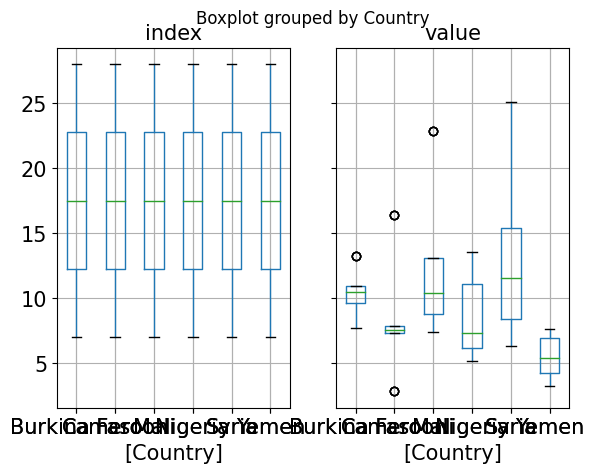

In [10]:
a = pd.melt(all_results, ignore_index=False).reset_index().groupby(["index", "Country", "Split", "Info"]).mean()
b = a.xs("variance", axis = 0, level = 3).reset_index()
b.boxplot(by=['Country'])